In [1]:
import math, pickle, os, copy, sys, scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import random
import matplotlib.pyplot as plt

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from utils_pv import *
from feature_selection import tune_pacf, rfecv_selection
from samples.data_sim import remove_feature, PVDataset

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)


In [2]:
exp_name = 'PV_UniModal'
filename_env = os.getcwd() + '/../../saved_results/' + exp_name + '_env'
file = open(filename_env+ '_raw', 'rb')

env_dict = pickle.load(file)
msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients'])
print(msg)
file.close()
print('\n'+env_dict['info'])

for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))
print('number of features = {:2.0f}'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[1]))

[INFO] loaded data for 24 clients

24 households at Lausanne - tilt_std: 5.0, az_std: 15.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 0.8, different module_name, different inverter_name, 
sml has 150 train and 610 validation samples
1y has 610 train and 610 validation samples
5y has 3050 train and 610 validation samples
15y has 9150 train and 610 validation samples
number of features =  9


### 1. Selecting a subset of weather info and temporal information 
* run on a subset of clients to reduce computations
* analysis based on 5 years data 

In [5]:
# reconstruct houses
from house_pv import reconstruct_house
scenario_name_recons='5y'
clients_subset = [12, 14, 15, 17, 22]
houses = [None] * env_dict['num_clients']
for client_num in clients_subset:
    houses[client_num] = reconstruct_house(
                            env_dict=env_dict, 
                            client_num=client_num, 
                            scenario_name=scenario_name_recons)
print('[INFO] reconstructed the ' + scenario_name_recons + ' scenario.')


[INFO] reconstructed the 5y scenario.


check correlation between features

[RES] observations:
H_sun and hourofd_y are highly correlated (|corr|=0.79)
H_sun and station_irrad_direct_prev are slightly correlated (|corr|=0.68)
H_sun and station_irrad_diffuse_prev are highly correlated (|corr|=0.84)
T2m and dayofy_y are slightly correlated (|corr|=0.67)
hourofd_y and station_irrad_direct_prev are slightly correlated (|corr|=0.52)
hourofd_y and station_irrad_diffuse_prev are slightly correlated (|corr|=0.74)
station_irrad_direct_prev and station_irrad_diffuse_prev are slightly correlated (|corr|=0.52)


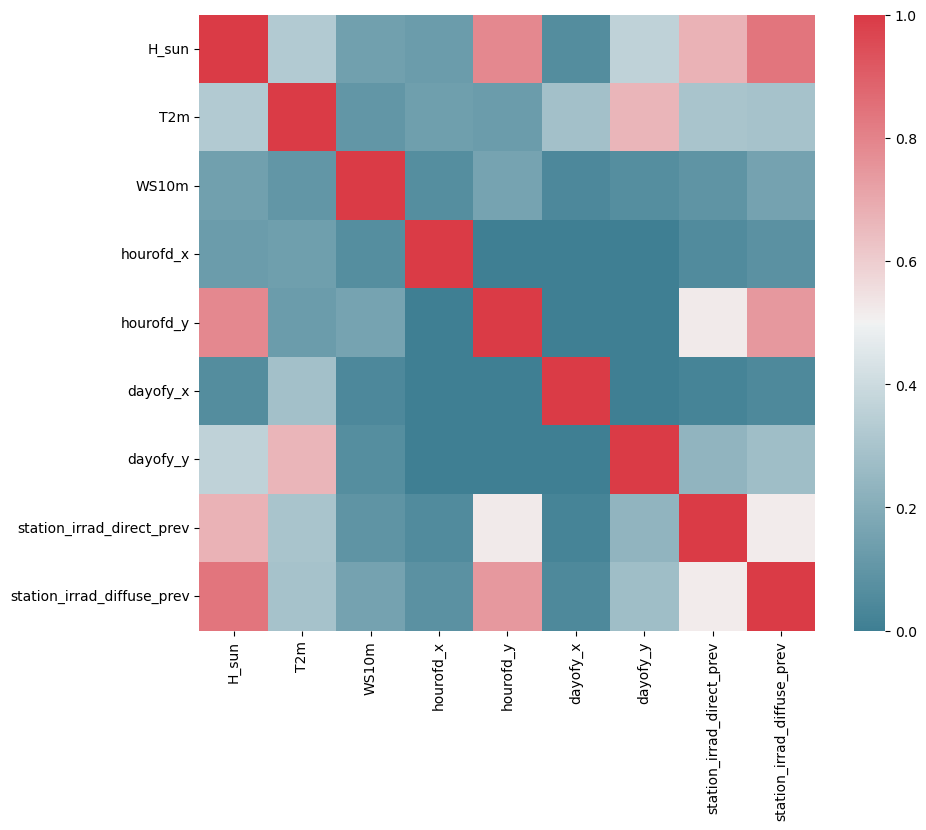

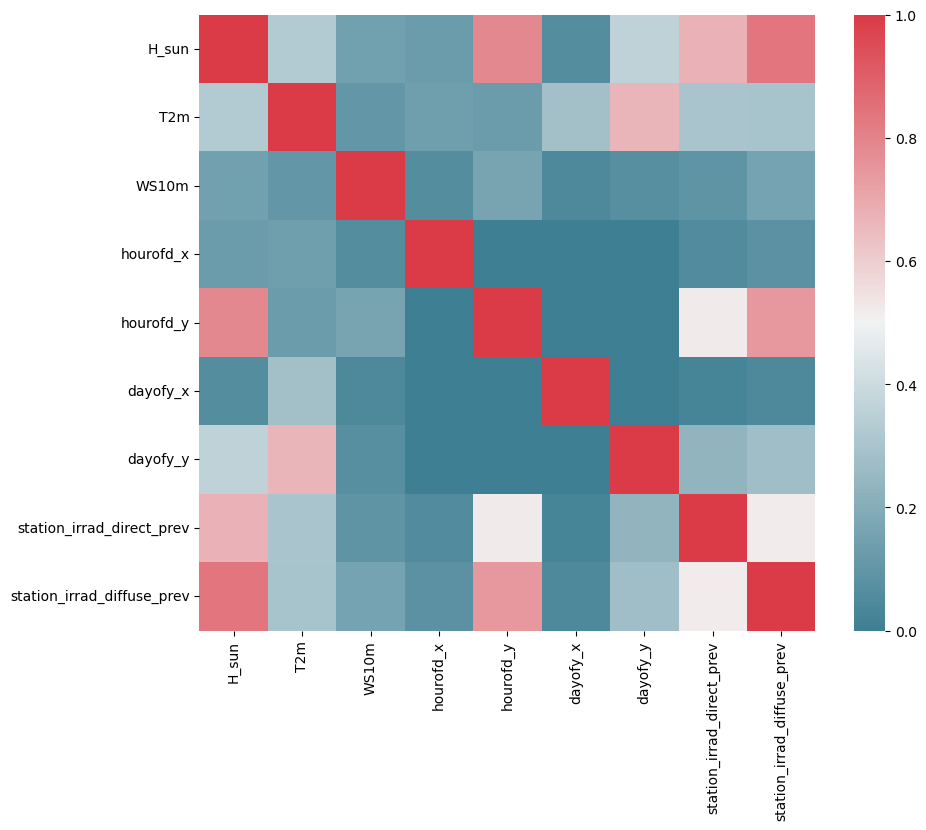

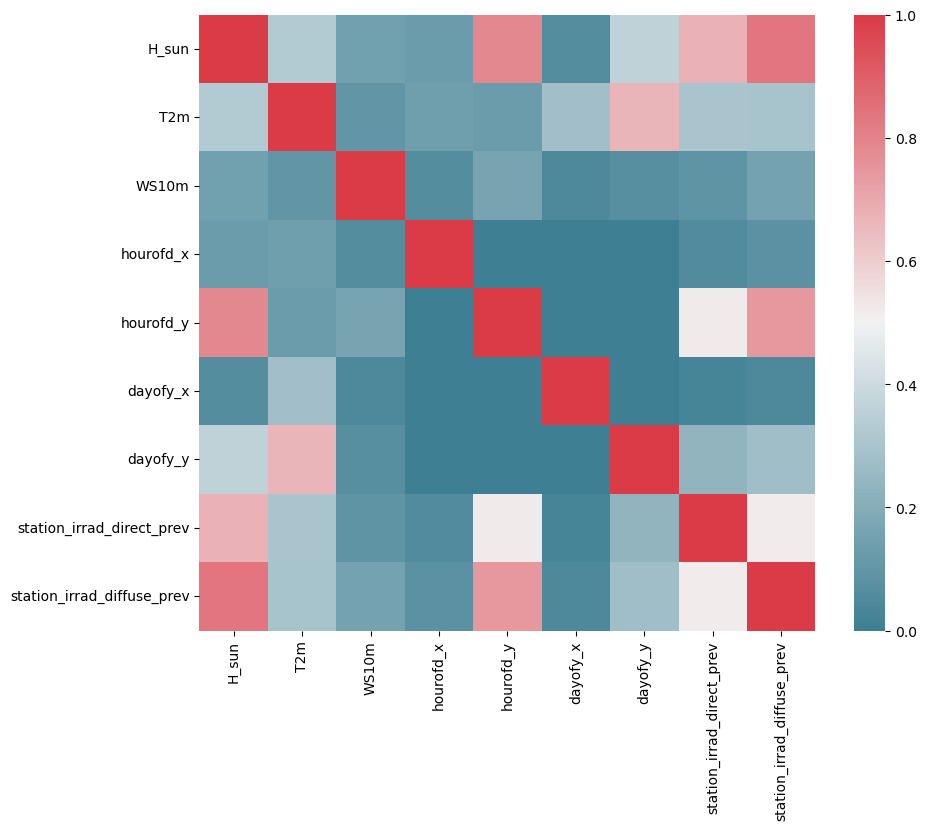

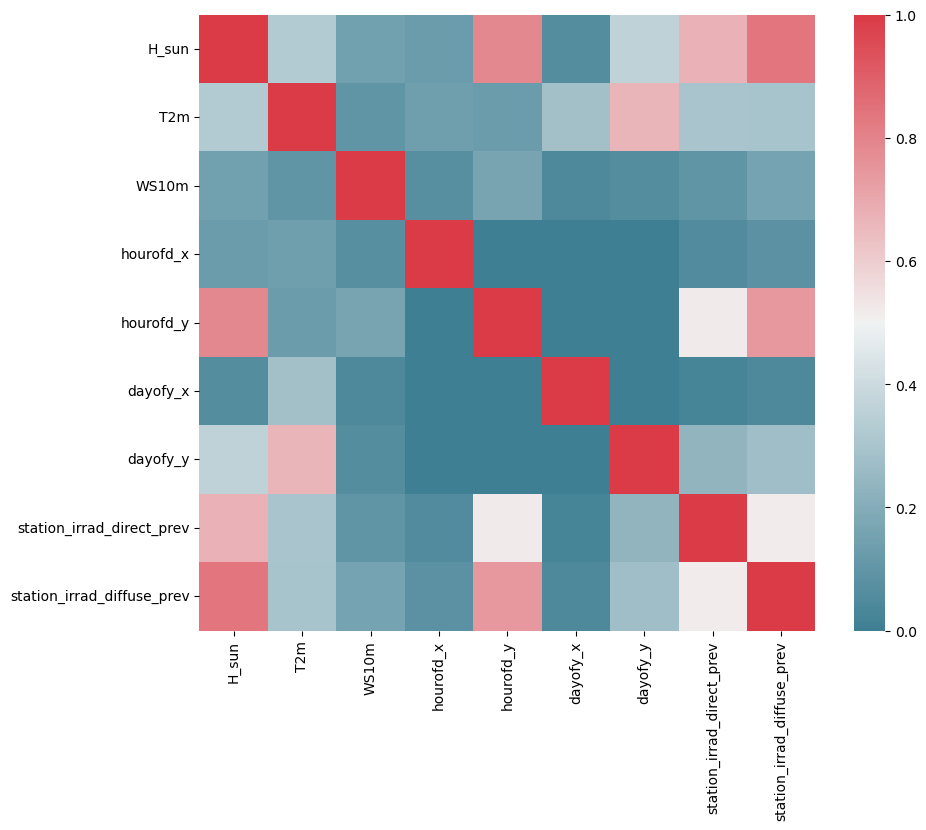

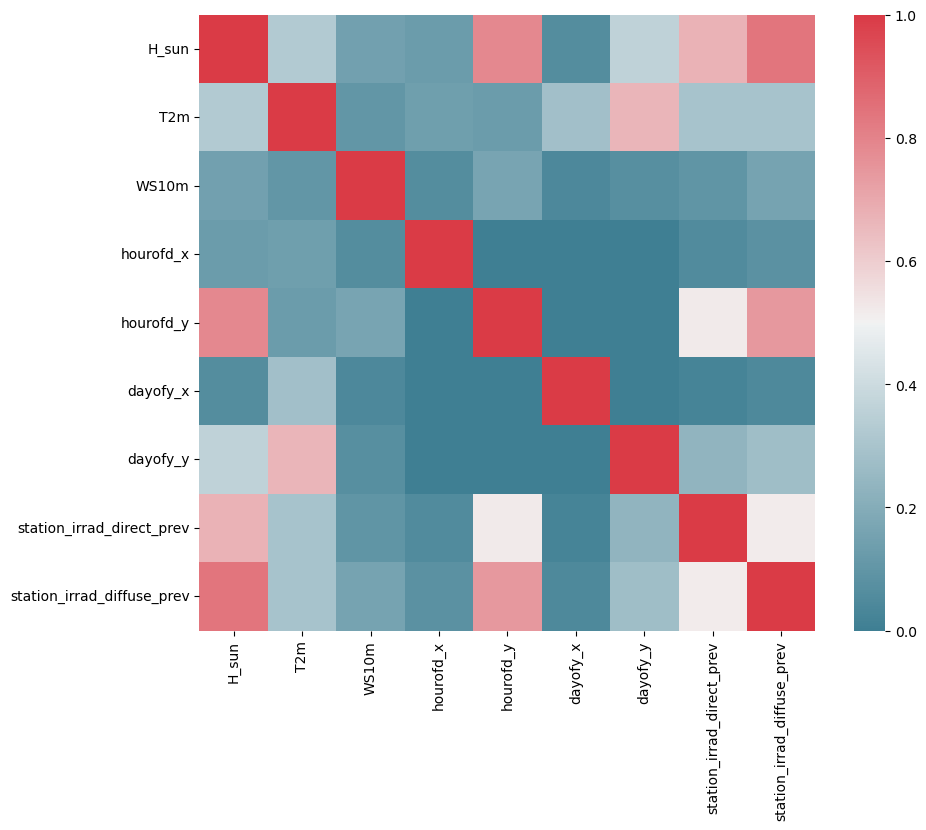

In [4]:
# correlation map between features
non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
corr_av = np.zeros((len(non_ar_feat_names), len(non_ar_feat_names)))
for client_num in clients_subset:
    # run correlation matrix and plot
    f, ax = plt.subplots(figsize=(10, 8))
    corr = houses[client_num].data_power.loc[:, non_ar_feat_names].corr()
    corr_av += np.abs(corr)
    sns.heatmap(np.abs(corr), mask=np.zeros_like(corr, dtype=bool),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
corr_av = corr_av/len(clients_subset)

msg = '[RES] observations:'
for row_ind, row in enumerate(corr_av.index):
    for col_ind, col in enumerate(corr_av.columns):
        if row_ind<col_ind:
            if np.abs(corr_av.iloc[row_ind, col_ind])>=0.75:
                msg += '\n' + row + ' and ' + col + ' are highly correlated (|corr|={:0.2f})'.format(np.abs(corr_av.iloc[row_ind, col_ind]))
            elif np.abs(corr_av.iloc[row_ind, col_ind])>=0.5:
                msg += '\n' + row + ' and ' + col + ' are slightly correlated (|corr|={:0.2f})'.format(np.abs(corr_av.iloc[row_ind, col_ind]))
print(msg)



In [5]:
# correlation with the power
non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
corr_out = pd.DataFrame(columns = ['Client '+str(client_num) for client_num in clients_subset])
for client_num in clients_subset:    
    corr_out.loc[:, 'Client '+str(client_num)] = houses[client_num].data_power.loc[:, non_ar_feat_names].corrwith(houses[client_num].data_power.loc[:, 'target'])
corr_out['Average'] = corr_out.mean(numeric_only=True, axis=1)
print(corr_out)


msg = '\n[RES] observations:'
for feature in corr_out.index:
    corr_feat = corr_out.loc[feature, 'Average']
    if np.abs(corr_feat)<0.05:
        msg += '\ncorrelation of ' + feature + ' with the output is very low'
print(msg)

                            Client 12  Client 14  Client 15  Client 17  \
H_sun                        0.845291   0.853946   0.863109   0.870899   
T2m                          0.252106   0.274727   0.265322   0.288364   
WS10m                        0.093958   0.123918   0.102458   0.118124   
hourofd_x                    0.172299   0.051996   0.152614   0.090663   
hourofd_y                   -0.653293  -0.684106  -0.674355  -0.684316   
dayofy_x                     0.041511   0.041919   0.043126   0.046937   
dayofy_y                    -0.248351  -0.246475  -0.260778  -0.278955   
station_irrad_direct_prev    0.787577   0.873970   0.805445   0.854712   
station_irrad_diffuse_prev   0.685932   0.740891   0.711507   0.740411   

                            Client 22   Average  
H_sun                        0.856323  0.857914  
T2m                          0.261688  0.268441  
WS10m                        0.105768  0.108845  
hourofd_x                    0.141509  0.121816  
hourofd_y

remove features that are correlated with each other or have a low correlation with the output

['H_sun', 'T2m', 'WS10m', 'hourofd_x', 'dayofy_y', 'station_irrad_direct_prev']


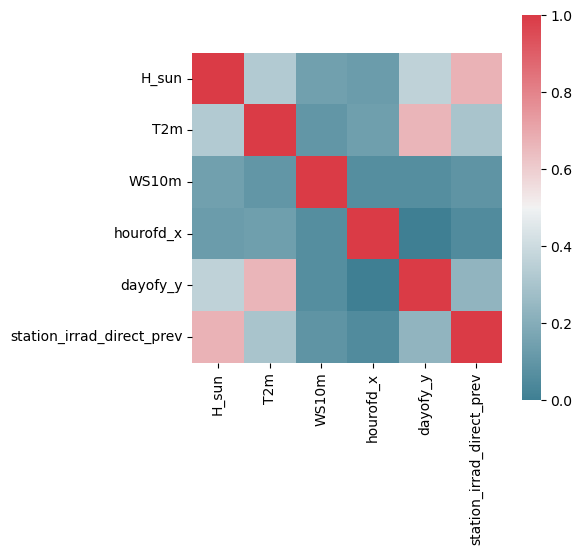

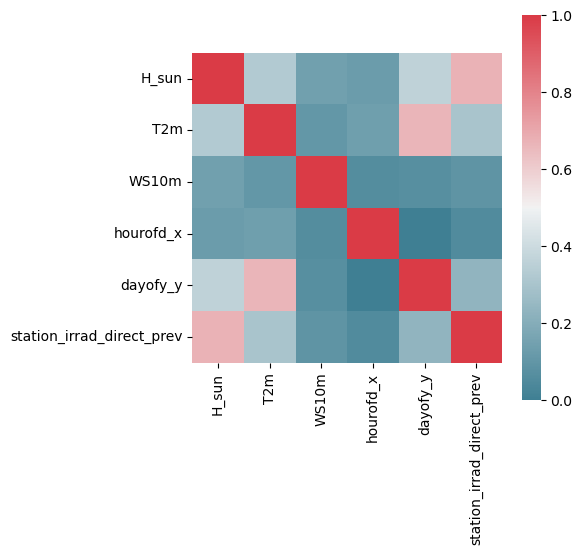

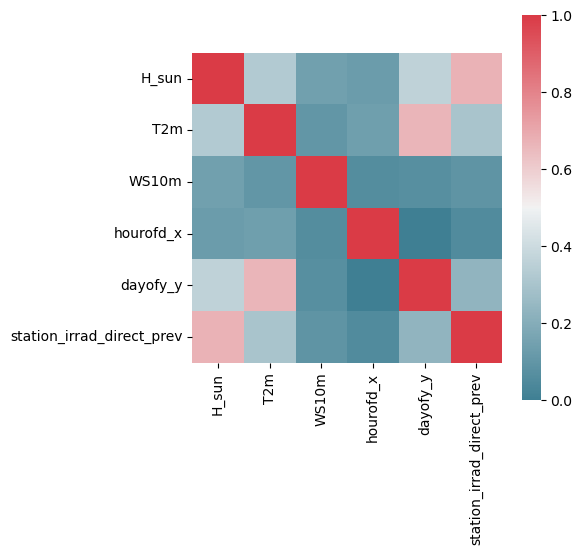

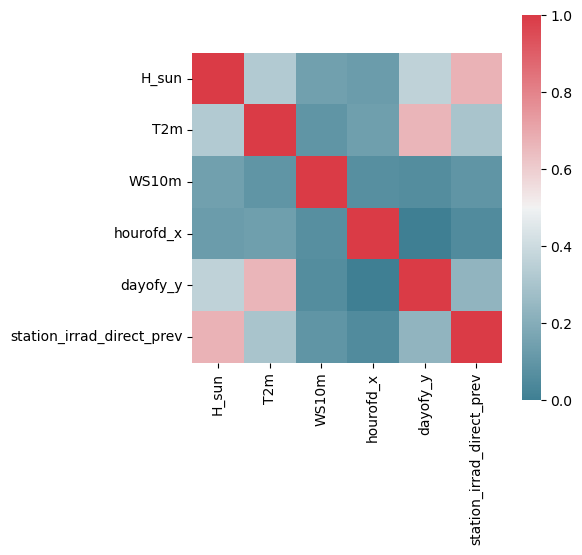

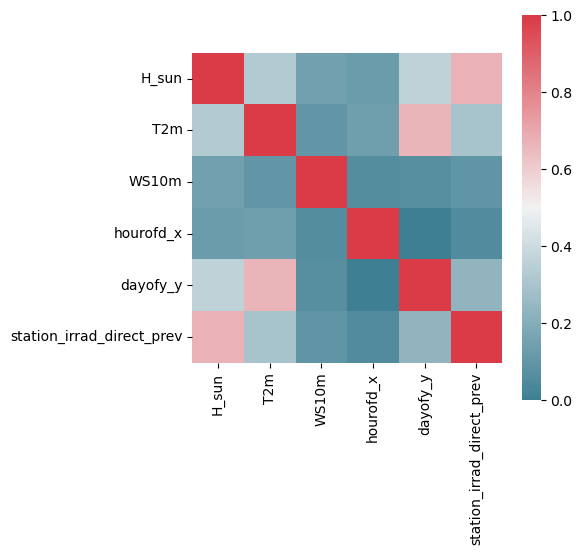

In [6]:
non_ar_feat_remove = ['hourofd_y', 'station_irrad_diffuse_prev', 'dayofy_x']
for feature_name in non_ar_feat_remove:
    remove_feature(
        env_dict=env_dict, 
        feature_name=feature_name, in_place=True)
    for house in houses:
        if not house is None:
            house.feature_names.remove(feature_name)

print(env_dict['feature_names'])
non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
for client_num in clients_subset:
    # run correlation matrix and plot
    f, ax = plt.subplots(figsize=(5, 5))
    corr = houses[client_num].data_power.loc[:, non_ar_feat_names].corr()
    sns.heatmap(np.abs(corr), mask=np.zeros_like(corr, dtype=bool),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)


# Selecting Features with RFECV
using a Ridge model with tuned penalty every time and Adj R2 scorer


[INFO] the following 49 constnat features were removed:  lag 12 lag 36 lag 60 lag 84 lag 108 lag 132 lag 156 lag 180 lag 181 lag 204 lag 205 lag 228 lag 229 lag 252 lag 253 lag 276 lag 277 lag 300 lag 301 lag 324 lag 325 lag 348 lag 349 lag 372 lag 373 lag 396 lag 397 lag 420 lag 421 lag 444 lag 445 lag 467 lag 468 lag 469 lag 491 lag 492 lag 493 lag 515 lag 516 lag 517 lag 539 lag 540 lag 541 lag 563 lag 564 lag 565 lag 587 lag 588 lag 589
[INFO] searching among 557 features
[INFO] the following 24 features were selected:
H_sun hourofd_x lag 1 lag 4 lag 23 lag 29 lag 30 lag 120 lag 121 lag 151 lag 485 lag 486


/opt/anaconda3/envs/py3.9.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


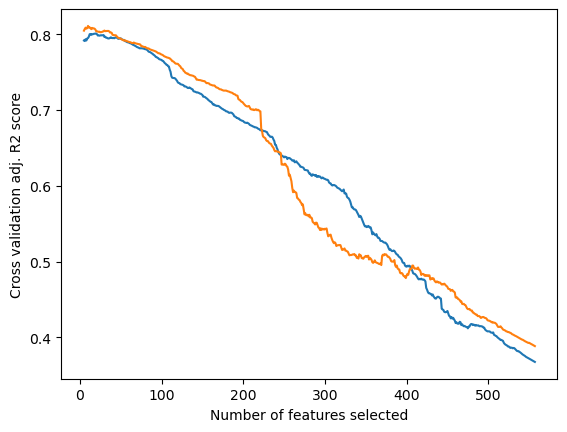

[INFO] the following 49 constnat features were removed:  lag 12 lag 36 lag 60 lag 84 lag 108 lag 132 lag 156 lag 180 lag 181 lag 204 lag 205 lag 228 lag 229 lag 252 lag 253 lag 276 lag 277 lag 300 lag 301 lag 324 lag 325 lag 348 lag 349 lag 372 lag 373 lag 396 lag 397 lag 420 lag 421 lag 444 lag 445 lag 467 lag 468 lag 469 lag 491 lag 492 lag 493 lag 515 lag 516 lag 517 lag 539 lag 540 lag 541 lag 563 lag 564 lag 565 lag 587 lag 588 lag 589
[INFO] searching among 557 features
[INFO] the following 24 features were selected:
H_sun hourofd_x dayofy_y station_irrad_direct_prev lag 1 lag 6 lag 8 lag 16 lag 18 lag 29 lag 30 lag 120 lag 121 lag 412 lag 413


/opt/anaconda3/envs/py3.9.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


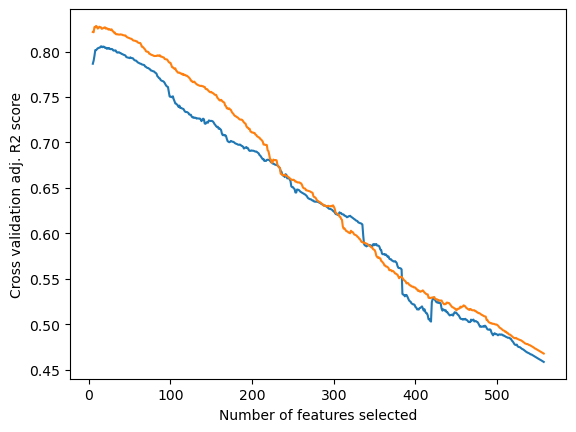

[INFO] the following 48 constnat features were removed:  lag 12 lag 36 lag 60 lag 84 lag 108 lag 132 lag 156 lag 180 lag 204 lag 205 lag 228 lag 229 lag 252 lag 253 lag 276 lag 277 lag 300 lag 301 lag 324 lag 325 lag 348 lag 349 lag 372 lag 373 lag 396 lag 397 lag 420 lag 421 lag 444 lag 445 lag 467 lag 468 lag 469 lag 491 lag 492 lag 493 lag 515 lag 516 lag 517 lag 539 lag 540 lag 541 lag 563 lag 564 lag 565 lag 587 lag 588 lag 589
[INFO] searching among 558 features
[INFO] the following 24 features were selected:
H_sun station_irrad_direct_prev lag 1 lag 4 lag 19 lag 40 lag 42 lag 120 lag 121 lag 436


/opt/anaconda3/envs/py3.9.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


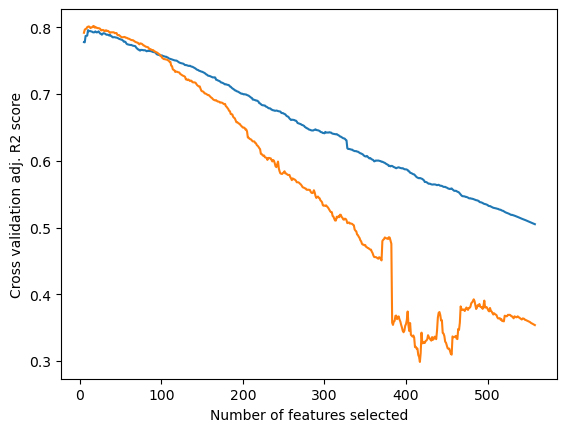

[INFO] the following 49 constnat features were removed:  lag 12 lag 36 lag 60 lag 84 lag 108 lag 132 lag 156 lag 180 lag 181 lag 204 lag 205 lag 228 lag 229 lag 252 lag 253 lag 276 lag 277 lag 300 lag 301 lag 324 lag 325 lag 348 lag 349 lag 372 lag 373 lag 396 lag 397 lag 420 lag 421 lag 444 lag 445 lag 467 lag 468 lag 469 lag 491 lag 492 lag 493 lag 515 lag 516 lag 517 lag 539 lag 540 lag 541 lag 563 lag 564 lag 565 lag 587 lag 588 lag 589
[INFO] searching among 557 features
[INFO] the following 24 features were selected:
H_sun station_irrad_direct_prev lag 1 lag 6 lag 19 lag 40 lag 42 lag 580 lag 581


/opt/anaconda3/envs/py3.9.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


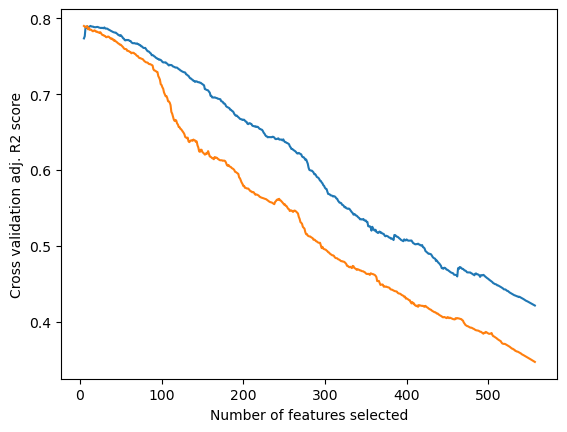

[INFO] the following 49 constnat features were removed:  lag 12 lag 36 lag 60 lag 84 lag 108 lag 132 lag 156 lag 180 lag 181 lag 204 lag 205 lag 228 lag 229 lag 252 lag 253 lag 276 lag 277 lag 300 lag 301 lag 324 lag 325 lag 348 lag 349 lag 372 lag 373 lag 396 lag 397 lag 420 lag 421 lag 444 lag 445 lag 467 lag 468 lag 469 lag 491 lag 492 lag 493 lag 515 lag 516 lag 517 lag 539 lag 540 lag 541 lag 563 lag 564 lag 565 lag 587 lag 588 lag 589
[INFO] searching among 557 features
[INFO] the following 24 features were selected:
H_sun station_irrad_direct_prev lag 1 lag 2 lag 3 lag 5 lag 19 lag 23 lag 29 lag 42 lag 452 lag 454 lag 575 lag 576


/opt/anaconda3/envs/py3.9.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


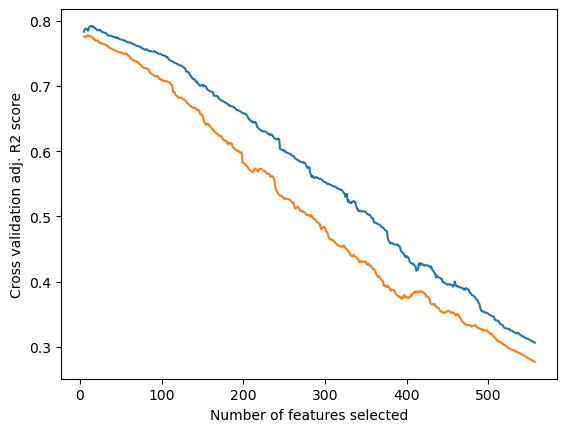

In [7]:
from sklearn.feature_selection import RFECV
from model_training.search_models import RidgeWrapper
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from house_pv import _augment_lags, remove_constant_cols


def adj_r2_scorer(estimator, X, y):
    y = y.flatten()
    y_pred = estimator.predict(X).flatten()
    R2 = r2_score(y, y_pred)
    n, p = X.shape
    return 1-(1-R2)*(n-1)/(n-p-1)

run_cell = True
if run_cell:
    # params
    cv = 2
    plot_fig = True
    days_look_back = 25
    keep_non_ar = False # forcee all non-ar features to remain
    min_features_to_select = 5

    # init
    selected_features = [None] * env_dict['num_clients']
    scenario = env_dict['train_scenarios'][scenario_name_recons]

    # all lags to try
    full_lags = np.arange(1, 
                    min(
                        24*days_look_back+1, 
                        math.floor(env_dict['train_scenarios'][scenario_name_recons]['clients_data'][0][0].shape[0]/cv)-1))
    full_lag_names = ['lag ' + str(x) for x in full_lags]

    # search
    for client_num in clients_subset:
        house = houses[client_num]
        # augment lags
        house.data_power = _augment_lags(
                                house.data_power, 
                                lags=full_lags, 
                                step_ahead=1)
        house.feature_names += full_lag_names
        for x in non_ar_feat_remove:
            assert not x in house.feature_names

        # construct regression matrices
        data_tuple = house.construct_regression_matrices(
                                m_train=scenario['m_train'],
                                train_years=scenario['train_years'],
                                exclude_last_year=scenario['exclude_last_year'])

        # remove constant lags
        house.data_power, data_tuple, house.feature_names = remove_constant_cols(
                                data_power=house.data_power, 
                                data_tuple=data_tuple, 
                                feature_names=house.feature_names)
        print('[INFO] searching among {:2.0f} features'.format(len(house.feature_names)))
        
        # fit Ridge regression with Grid search over penalty
        ridge_wrapper = RidgeWrapper(alphas=np.logspace(-6,2,20)) 
        
        # fit RFECV
        X_train, y_train, X_valid, y_valid = data_tuple
        selector = RFECV(
                    estimator=ridge_wrapper, step=1, cv=cv, 
                    scoring=adj_r2_scorer, 
                    min_features_to_select=min_features_to_select) 
        selector = selector.fit(X_train, y_train.flatten())
        
        #Force every non-lag feature to be in the RFECV
        if keep_non_ar:
            for i, feature_name in enumerate(house.feature_names):
                if not feature_name.startswith('lag'):
                    selector.support_[i] = True
                    
        selected_features[client_num] = [house.feature_names[i] for i, x in enumerate(selector.support_) if x]
        print('[INFO] the following {:2.0f} features were selected:'.format(len(selected_features)))
        print(*selected_features[client_num])

        # Plot number of features VS. cross-validation scores
        if plot_fig:
            plt.figure()
            plt.xlabel("Number of features selected")
            plt.ylabel("Cross validation adj. R2 score")
            plt.plot(range(min_features_to_select,
                            len(selector.grid_scores_) + min_features_to_select),
                        selector.grid_scores_)
            plt.show()


    # save
    file = open(os.getcwd() + "/../../saved_results/" + exp_name + "_feat_eng", 'wb')
    pickle.dump(
        {'selected_features':selected_features}, 
        file)
# load
else:
    file = open(os.getcwd() + "/../../saved_results/" + exp_name + "_feat_eng", 'rb')
    res = pickle.load(file)
    print(res.keys())
    selected_features = res['selected_features']
file.close()



Check which hours in the previous days were important

<BarContainer object of 24 artists>

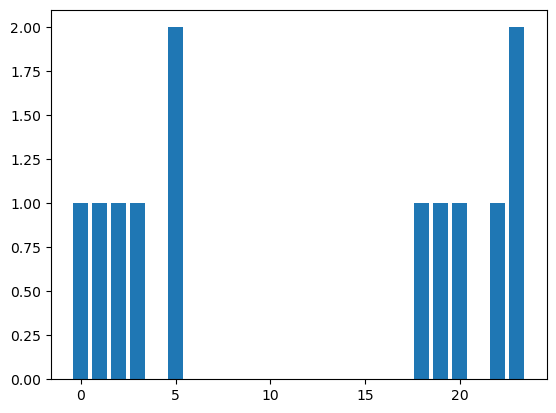

In [8]:
for client_num in clients_subset:
    if not selected_features[client_num] is None:
        lag_nums = [int(x.split()[-1]) for x in selected_features[client_num] if x.startswith('lag')]
        lag_nums_mod = [x%24 for x in lag_nums]
        counts = [lag_nums_mod.count(x) for x in np.arange(24)]

plt.bar(np.arange(24), counts)

Identify important features

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

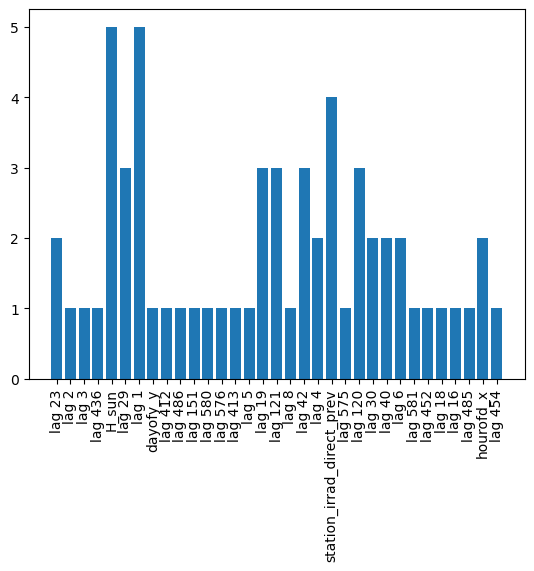

In [9]:
# analyze regressors
all_counts = []
for client_num in clients_subset:
    if not selected_features[client_num] is None:
        all_counts.extend([x for x in selected_features[client_num]])
counts = [all_counts.count(x) for x in set(all_counts)]
plt.bar(list(set(all_counts)), counts)
plt.xticks(rotation=90)

### Feature Selection using PACF

[INFO] the following constnat features were removed:  lag 12 lag 467 lag 180 lag 637 lag 587 lag 588 lag 445 lag 611 lag 517 lag 108 lag 421 lag 397 lag 228 lag 252 lag 563 lag 709 lag 493 lag 469 lag 539 lag 685 lag 541 lag 613 lag 204 lag 60 lag 659 lag 348 lag 444 lag 589 lag 684 lag 36 lag 276 lag 540 lag 612 lag 492 lag 516 lag 661 lag 156 lag 565 lag 708 lag 396 lag 515 lag 660 lag 132 lag 491 lag 564 lag 300 lag 636 lag 707 lag 635 lag 372 lag 683 lag 84 lag 420 lag 324 lag 373 lag 468
(9150, 6)
Train R2 scores:  0.7117134759685237 0.7097311168702753 0.7078436530463448 0.7151707860419412 0.7136317749670413
Test  R2 scores:  0.7102648582647992 0.7187619684578264 0.7261611975484661 0.6963123903634212 0.7026715517869228
Mean absolute error: train 10.2689, test 10.0906
Mean squared error:  train 156.2150, test 148.3861
Explained Variance Score (best=1): train 0.7078, test 0.7262
Coefficient of determination (R2): train 0.7078, test 0.7262
Adjusted coeff. of determination:  train 0.7

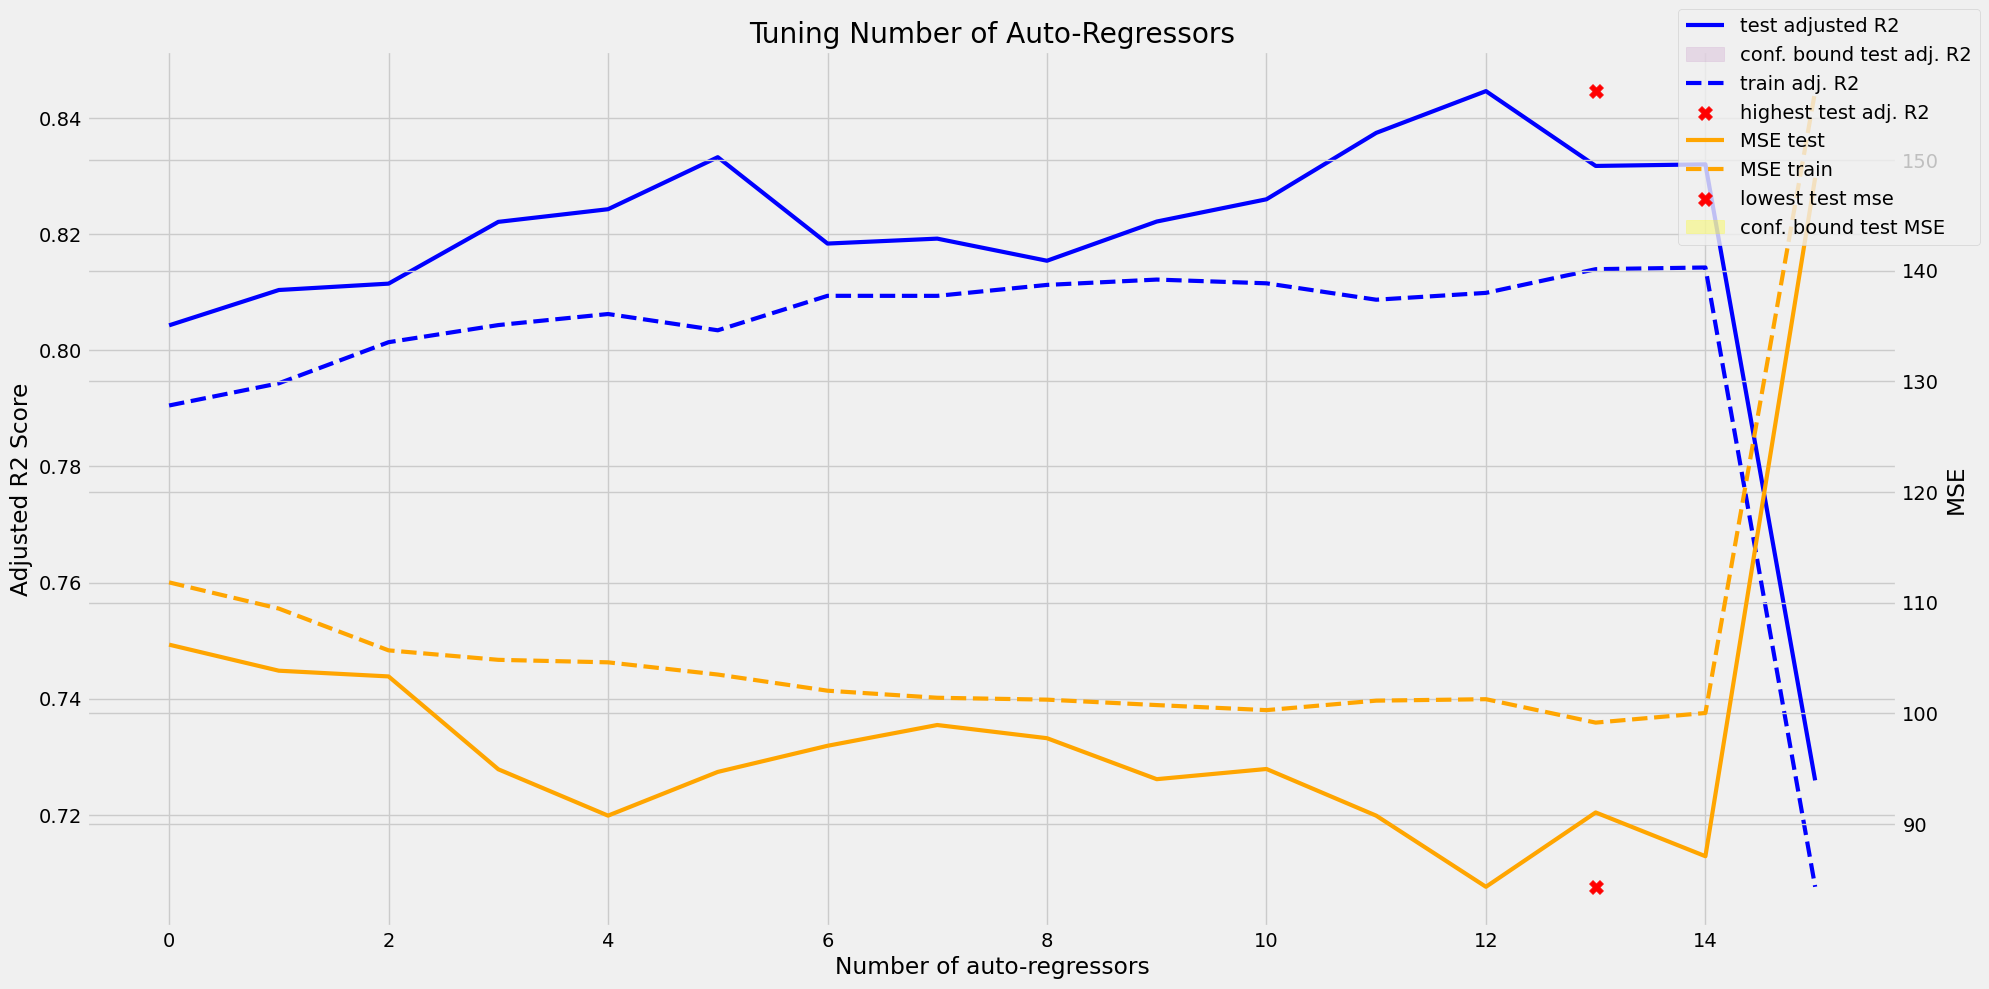

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			13				0.8446			14.1062		84.3373
min MSE:			13				0.8446			14.1062		84.3373
first in range:			5				0.8243			-2.0407		90.7660
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 20 21
[RES] lags by lowest adj r2:  1 2 3 20 21 19 22 18 23 25 17 45 9
(139655, 567)
[INFO] the following constnat features were removed:  lag 12 lag 467 lag 36 lag 349 lag 563 lag 469 lag 373 lag 587 lag 421 lag 611 lag 491 lag 707 lag 397 lag 180 lag 493 lag 515 lag 517 lag 637 lag 541 lag 683 lag 709 lag 661 lag 539 lag 588 lag 565 lag 613 lag 685 lag 468 lag 492 lag 204 lag 659 lag 516 lag 589 lag 445 lag 396 lag 300 lag 132 lag 420 lag 635 lag 252 lag 540 lag 372 lag 60 lag 636 lag 108 lag 324 lag 156 lag 84 lag 228 lag

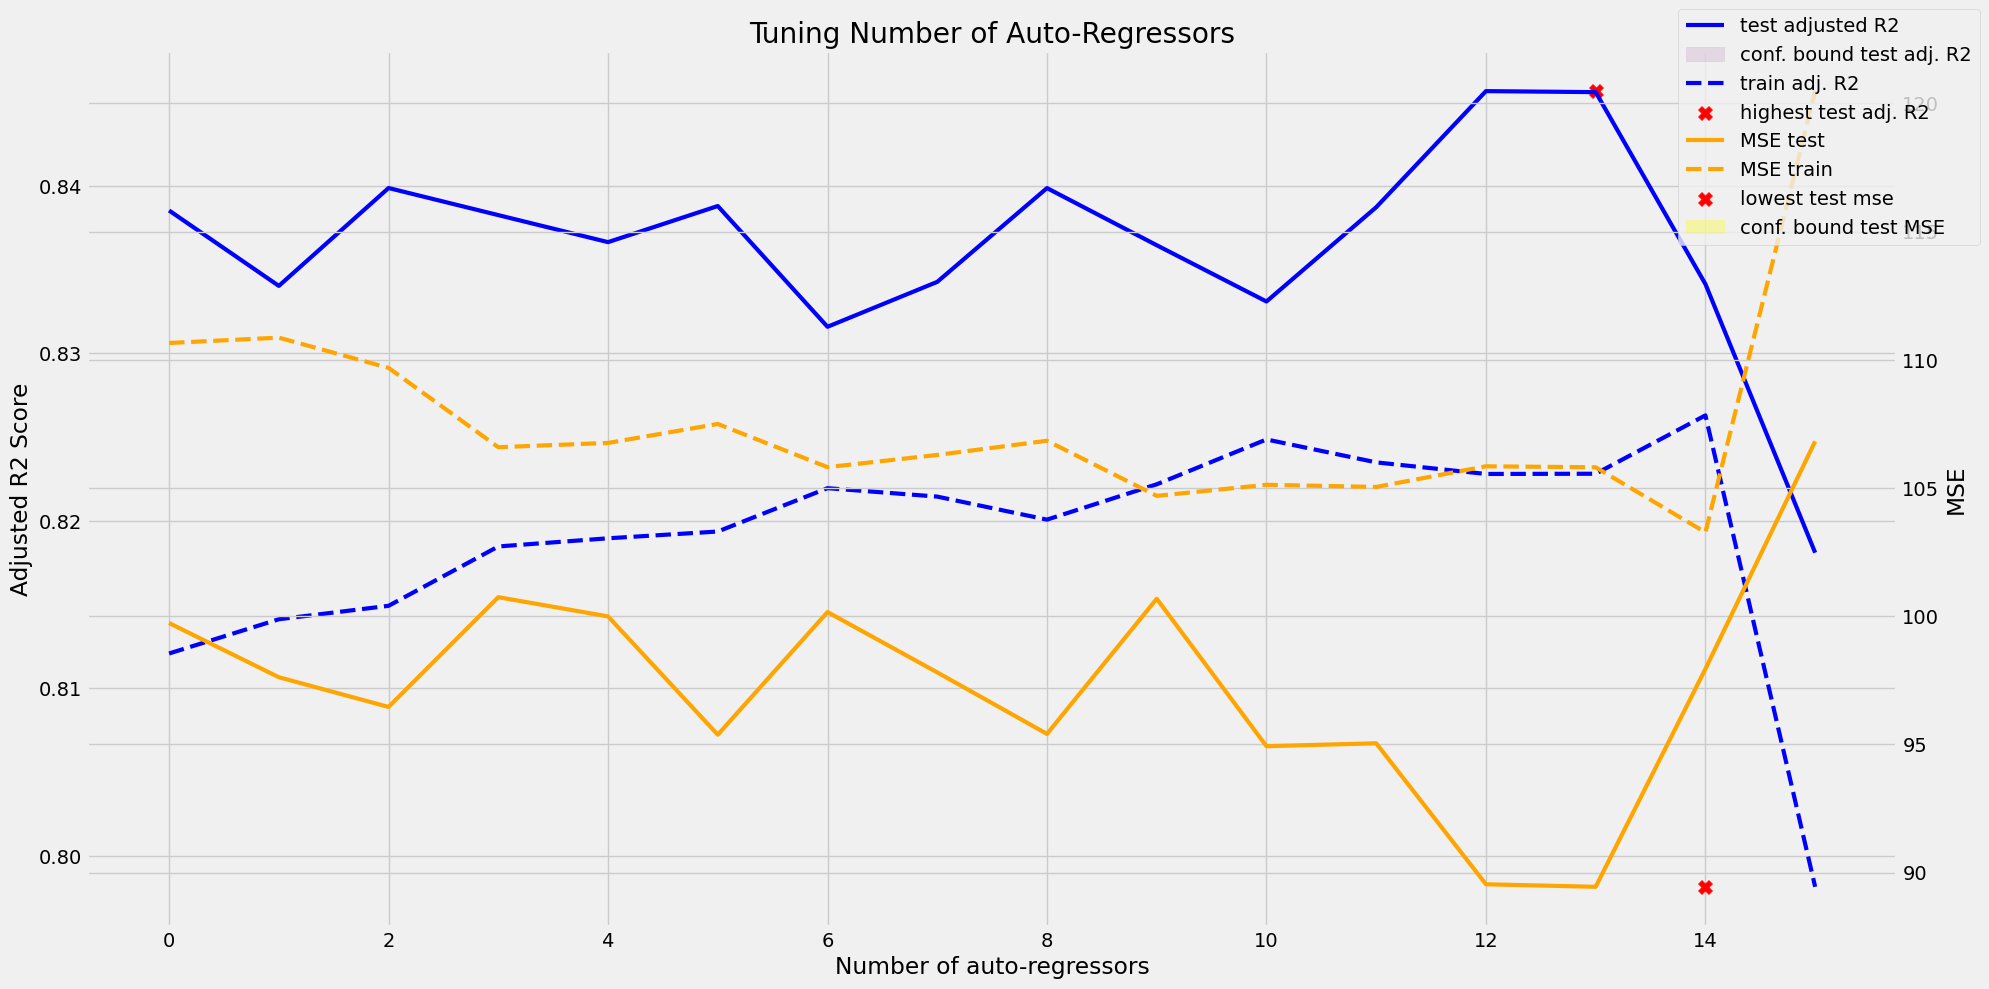

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			13				0.8457			13.9863		89.5477
min MSE:			14				0.8456			15.9885		89.4495
first in range:			2				0.8340			-8.1864		97.6231
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2
[RES] lags by lowest adj r2:  1 2 3 20 19 21 18 22 23 25 17 4 10
(139655, 567)
[INFO] the following constnat features were removed:  lag 12 lag 36 lag 60 lag 467 lag 84 lag 611 lag 539 lag 563 lag 587 lag 397 lag 445 lag 421 lag 108 lag 707 lag 515 lag 637 lag 156 lag 588 lag 132 lag 516 lag 517 lag 541 lag 684 lag 493 lag 659 lag 685 lag 300 lag 492 lag 396 lag 683 lag 204 lag 565 lag 372 lag 635 lag 491 lag 613 lag 636 lag 373 lag 660 lag 469 lag 324 lag 420 lag 468 lag 589 lag 709 lag 252 lag 564 lag 661 lag 228 lag 348 lag

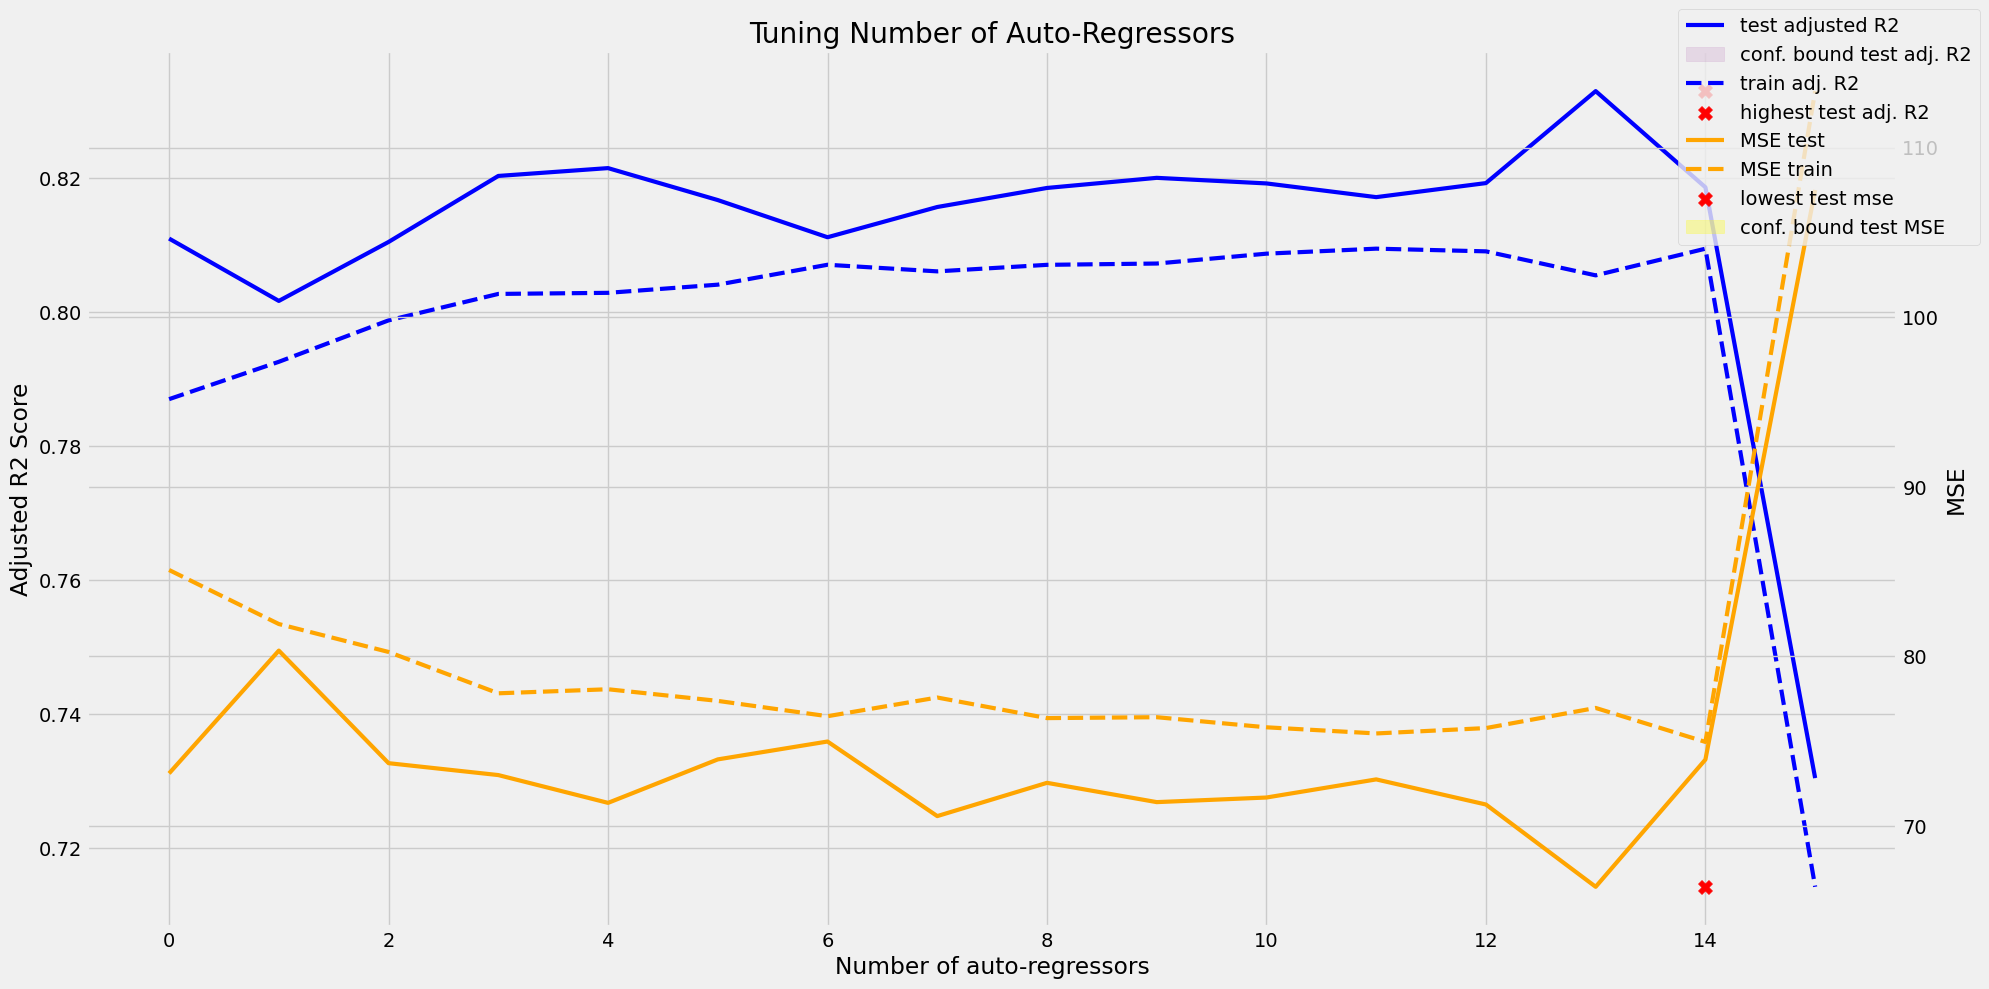

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			14				0.8330			16.5840		66.4158
min MSE:			14				0.8330			16.5840		66.4158
first in range:			4				0.8203			-3.6052		73.0043
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 21
[RES] lags by lowest adj r2:  1 2 3 21 20 19 22 18 17 23 25 4 45 46
(139655, 568)
[INFO] the following constnat features were removed:  lag 12 lag 36 lag 60 lag 84 lag 108 lag 467 lag 611 lag 563 lag 156 lag 587 lag 707 lag 204 lag 539 lag 132 lag 397 lag 445 lag 300 lag 324 lag 372 lag 491 lag 683 lag 516 lag 492 lag 515 lag 588 lag 613 lag 659 lag 493 lag 396 lag 541 lag 565 lag 589 lag 612 lag 373 lag 517 lag 421 lag 420 lag 444 lag 349 lag 180 lag 684 lag 637 lag 228 lag 660 lag 685 lag 635 lag 540 lag 469 lag 564 lag

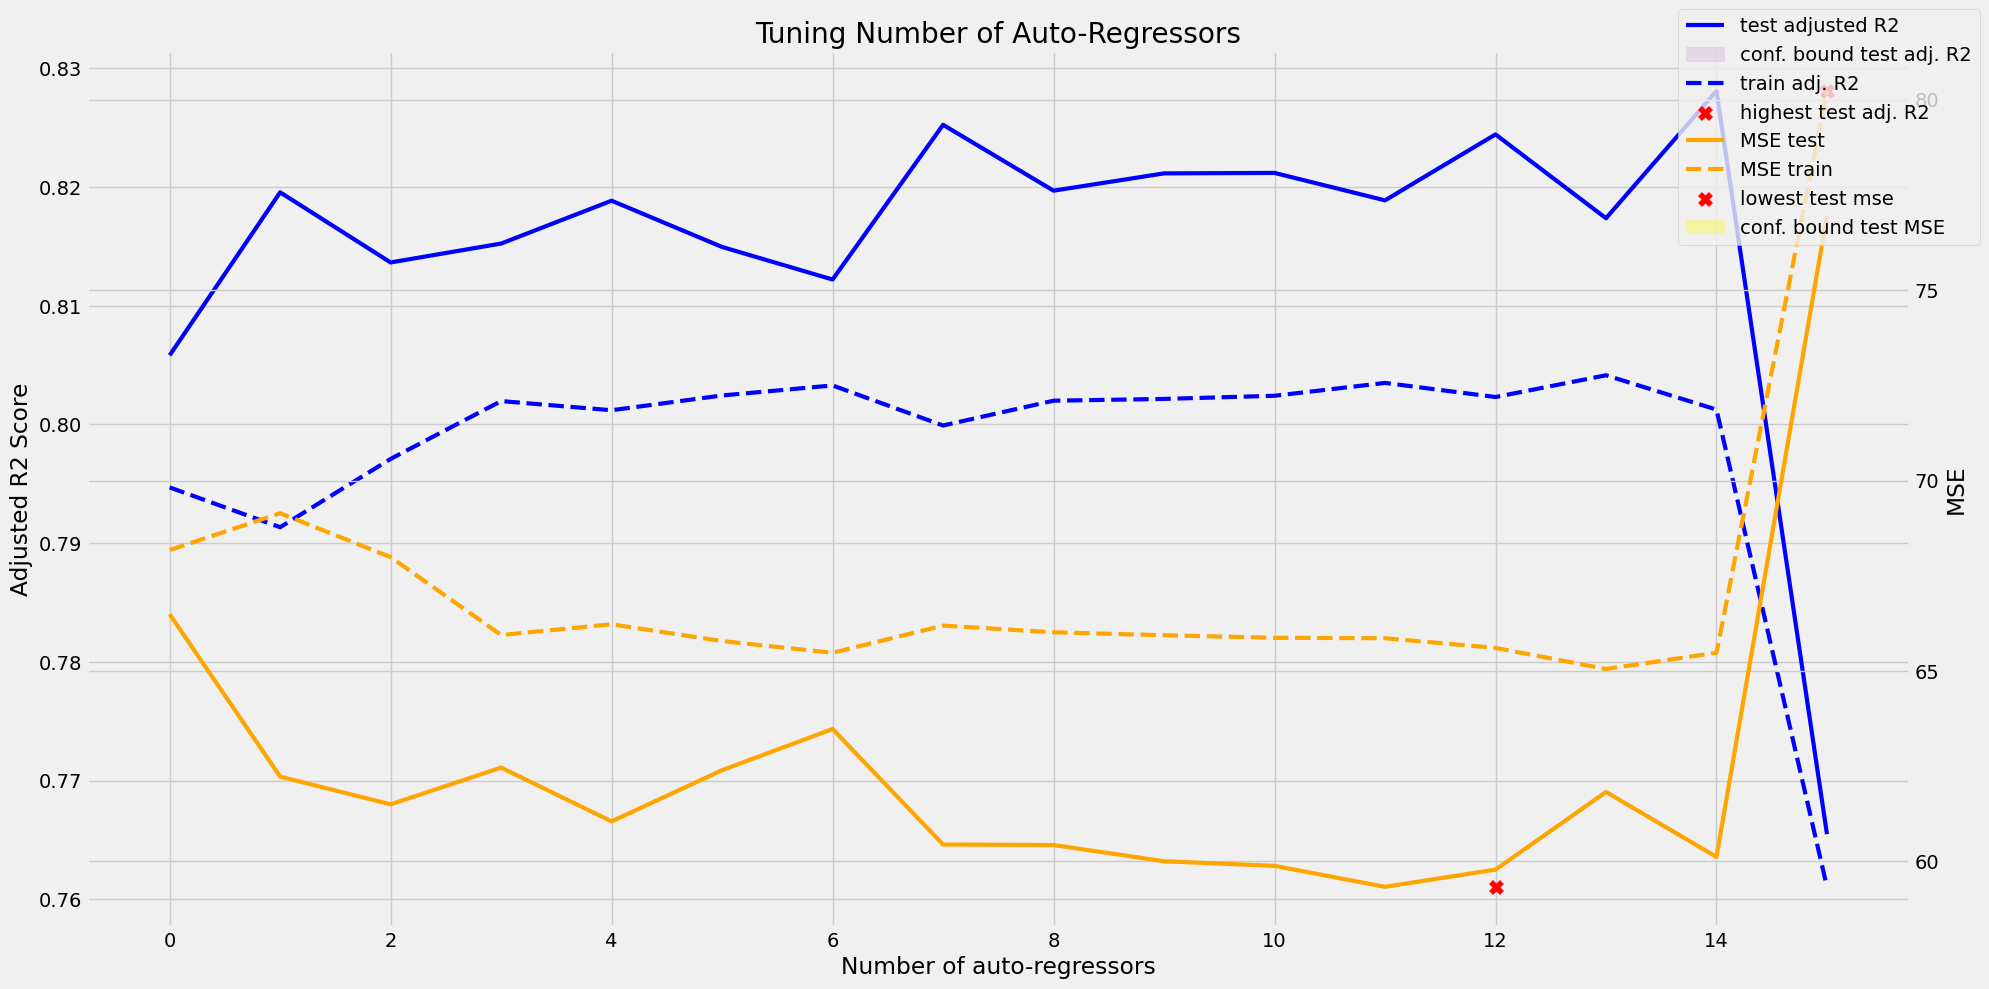

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			15				0.8281			18.7832		60.1200
min MSE:			12				0.8189			12.8094		59.3354
first in range:			2				0.8196			-7.2857		62.2267
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2
[RES] lags by lowest adj r2:  1 2 3 20 21 19 18 22 17 4 23 16 25 11 46
(139655, 567)
[INFO] the following constnat features were removed:  lag 12 lag 36 lag 60 lag 84 lag 467 lag 611 lag 587 lag 516 lag 397 lag 252 lag 492 lag 348 lag 563 lag 684 lag 421 lag 445 lag 637 lag 469 lag 228 lag 539 lag 276 lag 108 lag 420 lag 588 lag 132 lag 564 lag 683 lag 636 lag 180 lag 613 lag 660 lag 517 lag 708 lag 659 lag 635 lag 515 lag 156 lag 589 lag 685 lag 300 lag 493 lag 491 lag 468 lag 612 lag 204 lag 541 lag 709 lag 325 lag 349 lag 3

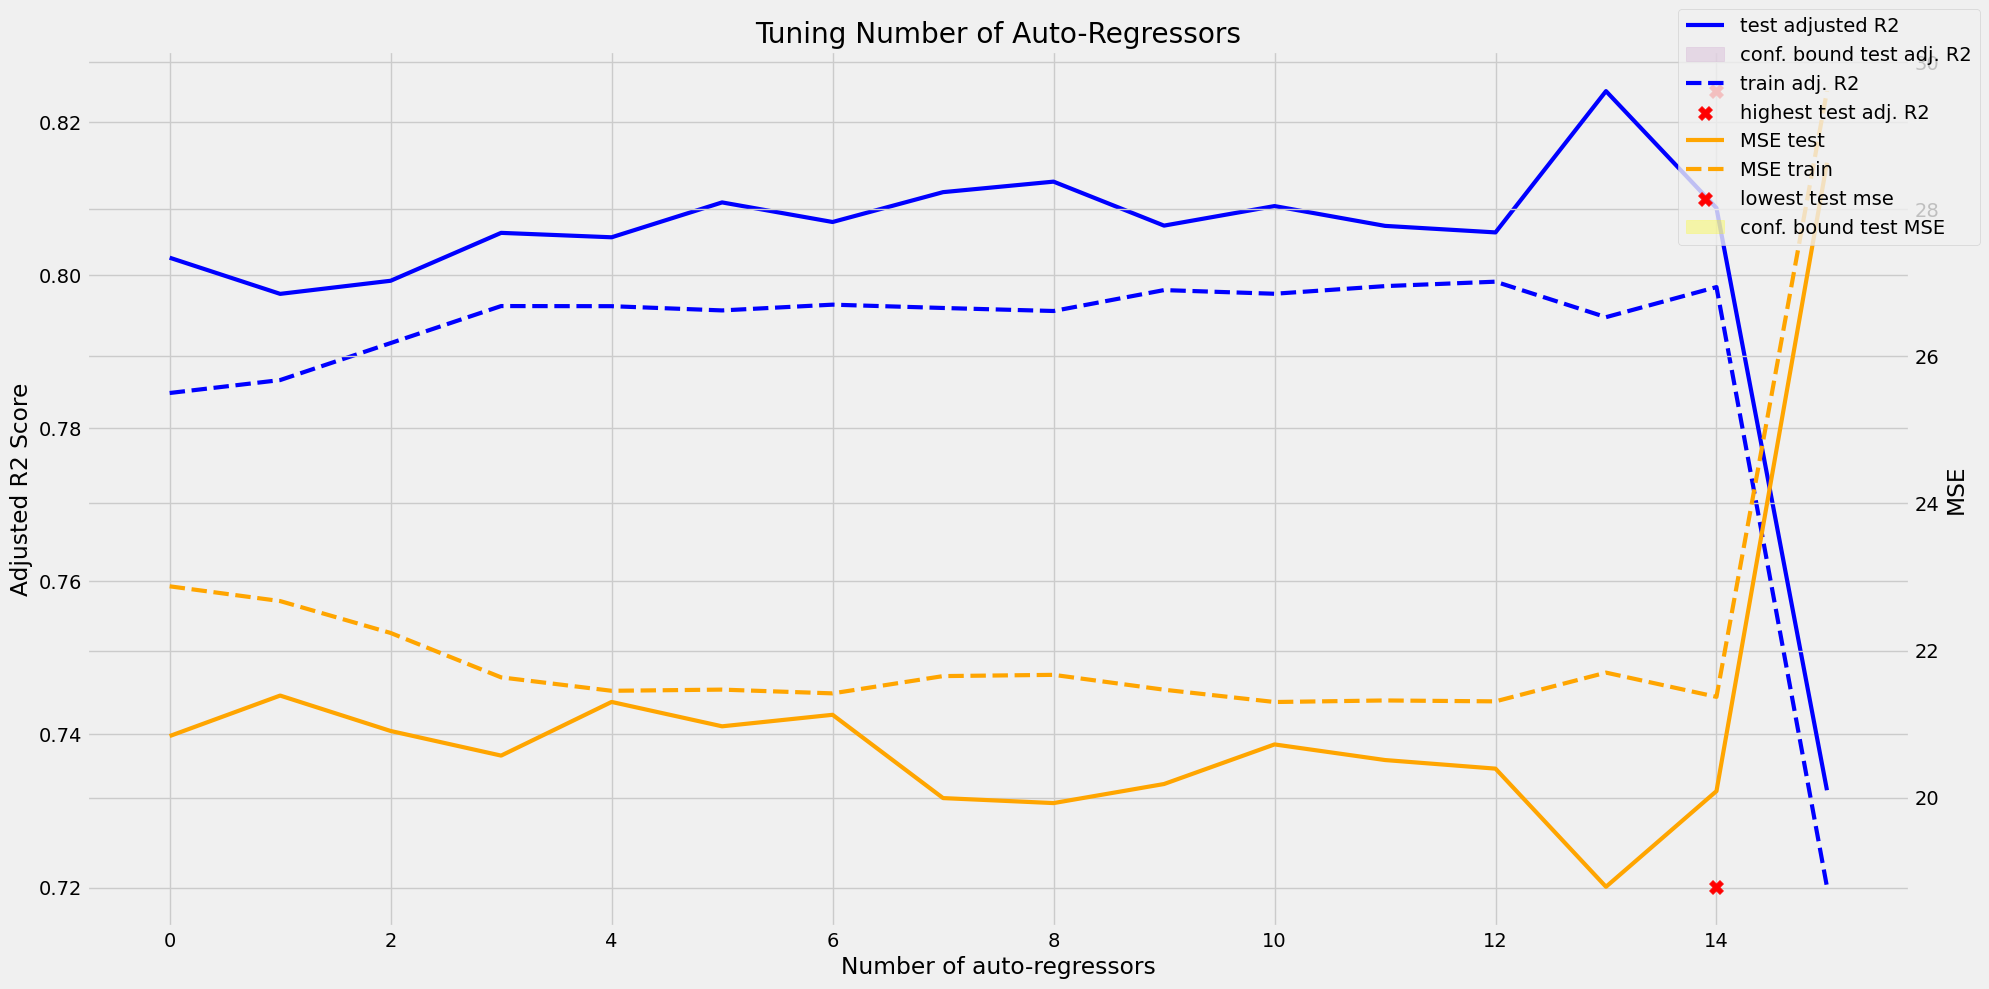

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			14				0.8240			19.1093		18.7889
min MSE:			14				0.8240			19.1093		18.7889
first in range:			4				0.8055			-1.0721		20.5726
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 20
[RES] lags by lowest adj r2:  1 2 3 20 19 21 18 22 17 4 23 25 10 11
(139655, 567)


In [10]:
# selecting the lags
first_in_range, best_num_r = [None]*env_dict['num_clients'], [None]*env_dict['num_clients']
best_num_m, sorted_lags = [None]*env_dict['num_clients'], [None]*env_dict['num_clients']
for client_num in clients_subset:
    first_in_range[client_num], best_num_r[client_num], best_num_m[client_num], sorted_lags[client_num] = tune_pacf(
                    house=houses[client_num], max_num_lags=15, max_num_days=30,
                    step_ahead=1, repeats=1, verbose=True)
    print('[RES] lags by first in range: ', *sorted_lags[client_num][:first_in_range[client_num]])
    print('[RES] lags by lowest adj r2: ', *sorted_lags[client_num][:best_num_r[client_num]])
    print(houses[client_num].data_power.shape)


# Feature Selection Based on Several Houses

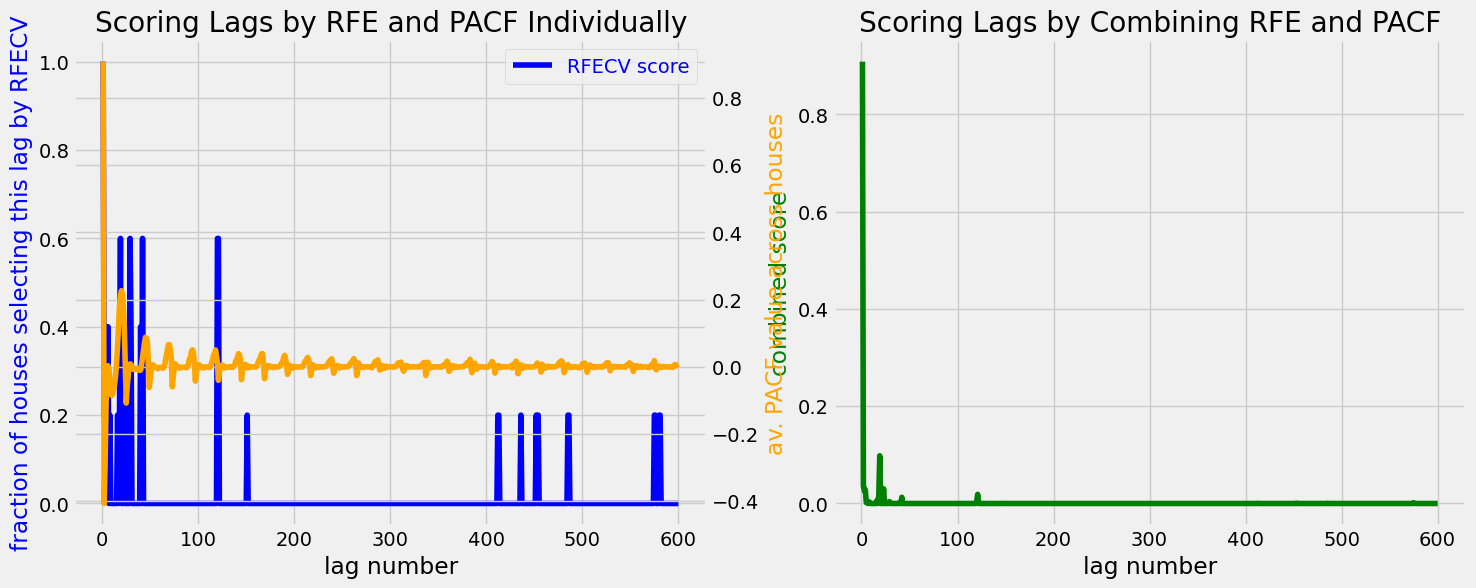

[INFO] sorted lags:  lag 1 lag 19 lag 2 lag 23 lag 4 lag 3 lag 121 lag 18 lag 42 lag 16 lag 120 lag 29 lag 8 lag 40 lag 5 lag 30 lag 575 lag 6 lag 485 lag 454 lag 452 lag 576 lag 413 lag 412 lag 151 lag 580 lag 486 lag 581 lag 436


In [18]:
import statsmodels.tsa.stattools as sttools
alpha = 1.5 # NOTE: weights the two xcoring methods
# analyze auto-regressors
# --- COMPUTE AV PACF SCORES ---
pacf_val = np.zeros(full_lags[-1]+1)
for client_num in clients_subset:
    powers = houses[client_num].data_power.loc[:, 'target'].values
    pacf_val += sttools.pacf(powers, nlags=full_lags[-1])
pacf_score = [x/len(clients_subset) for x in pacf_val]


# --- COMPUTE AV RFECV SCORES ---
all_lag_nums = [] # convert all lags to int and put in a list
for client_num in clients_subset:
    if not selected_features[client_num] is None:
        all_lag_nums.extend([int(x.split()[-1]) for x in selected_features[client_num] if x.startswith('lag')])
counts = [all_lag_nums.count(x) for x in np.arange(full_lags[-1]+1)] # count how many times each lag appears
rfe_score = [x/len(clients_subset) for x in counts]


# --- PLOT ---
fig, axs = plt.subplots(1, 2, figsize=(16,6))
ax_rfe = axs[0]
ax_pacf = ax_rfe.twinx()
ax_rfe.set_title('Scoring Lags by RFE and PACF Individually')
ax_rfe.set_xlabel("lag number")
ax_rfe.set_ylabel("fraction of houses selecting this lag by RFECV")
ax_pacf.set_ylabel("av. PACF value across houses")
p1, = ax_rfe.plot(np.arange(1, full_lags[-1]+1), 
            rfe_score[1:], 
            label="RFECV score", c='b')
p2, = ax_pacf.plot(np.arange(1, full_lags[-1]+1), 
            pacf_score[1:], 
            label="PACF score", c='orange')
ax_rfe.legend(labelcolor="linecolor")
ax_rfe.yaxis.get_label().set_color(p1.get_color())
ax_pacf.yaxis.get_label().set_color(p2.get_color())

# final selection method
score = np.array([(x**alpha)*abs(y) for x,y in zip(rfe_score, pacf_score)])
p3, = axs[1].plot(np.arange(1, full_lags[-1]+1), 
            score[1:], 
            label="combined score", c='g')
axs[1].set_title('Scoring Lags by Combining RFE and PACF')
axs[1].set_xlabel("lag number")
axs[1].set_ylabel("combined score")
axs[1].yaxis.get_label().set_color(p3.get_color())
axs[1].yaxis.get_label().set_color(p3.get_color())
plt.show()

# --- SORT LAGS --- 
# sort lags with a positive score
N = len([x for x in score if x>0])
sorted_lag_nums = np.flip(
                        sorted(
                            range(len(score)), 
                            key = lambda sub: score[sub]
                            )[-N:]
                        )
sorted_lags = ['lag ' + str(x) for x in sorted_lag_nums]
print('[INFO] sorted lags: ', *sorted_lags)


## Tuning the Number of Features

In [19]:
selected_non_ar = []
for client_num in clients_subset:
    if not selected_features[client_num] is None:
        selected_non_ar.extend([x for x in selected_features[client_num] if not x.startswith('lag')])
selected_non_ar = list(set(selected_non_ar))
env_dict['feature_names'] = selected_non_ar

del houses
# reconstruct houses
houses = [None] * env_dict['num_clients']
for client_num in clients_subset:
    houses[client_num] = reconstruct_house(
                            env_dict=env_dict, 
                            client_num=client_num, 
                            scenario_name=scenario_name_recons)
print('[INFO] reconstructed the ' + scenario_name_recons + ' scenario.')


[INFO] reconstructed the 5y scenario.


In [20]:
# fit model with the selected features for each house
selected_feat = selected_non_ar + sorted_lags

all_rmses = np.zeros((len(houses), len(sorted_lags)+1))
all_adjr2s = np.zeros((len(houses), len(sorted_lags)+1))

# effect of num of features on performance for each house
for client_num in clients_subset:
    house = houses[client_num]

    # augment lags
    house.data_power = _augment_lags(
                            house.data_power, 
                            lags=sorted_lag_nums, 
                            step_ahead=1)
    house.feature_names = selected_feat
    
    # construct regression matrices
    data_tuple = house.construct_regression_matrices(
                            m_train=scenario['m_train'],
                            train_years=scenario['train_years'],
                            exclude_last_year=scenario['exclude_last_year'])

    X_train, y_train, X_valid, y_valid = data_tuple
    assert X_train.shape[1] == len(selected_feat)
    
    # drop features one by one
    for num_lags in np.arange(len(sorted_lags)+1):
        cols_red = np.arange(len(selected_non_ar)+num_lags) 
        X_train_red = X_train[:, cols_red]
        X_valid_red = X_valid[:, cols_red]

        # fit Ridge regression with Grid search over penalty
        ridge_wrapper = RidgeWrapper(
                                alphas=np.logspace(-6,2,20), 
                                flatten_y = True, 
                                normalize_data=True) 
        ridge_wrapper.fit(X_train_red, y_train)

        # evaluate on validation data
        y_valid_pred = ridge_wrapper.predict(X_valid_red)
        y_valid_pred = y_valid_pred.reshape(y_valid.shape)
        all_rmses[client_num, num_lags] = np.mean((y_valid_pred-y_valid)**2)**0.5
        all_adjr2s[client_num, num_lags] = adj_r2_scorer(ridge_wrapper, X_valid_red, y_valid)


        

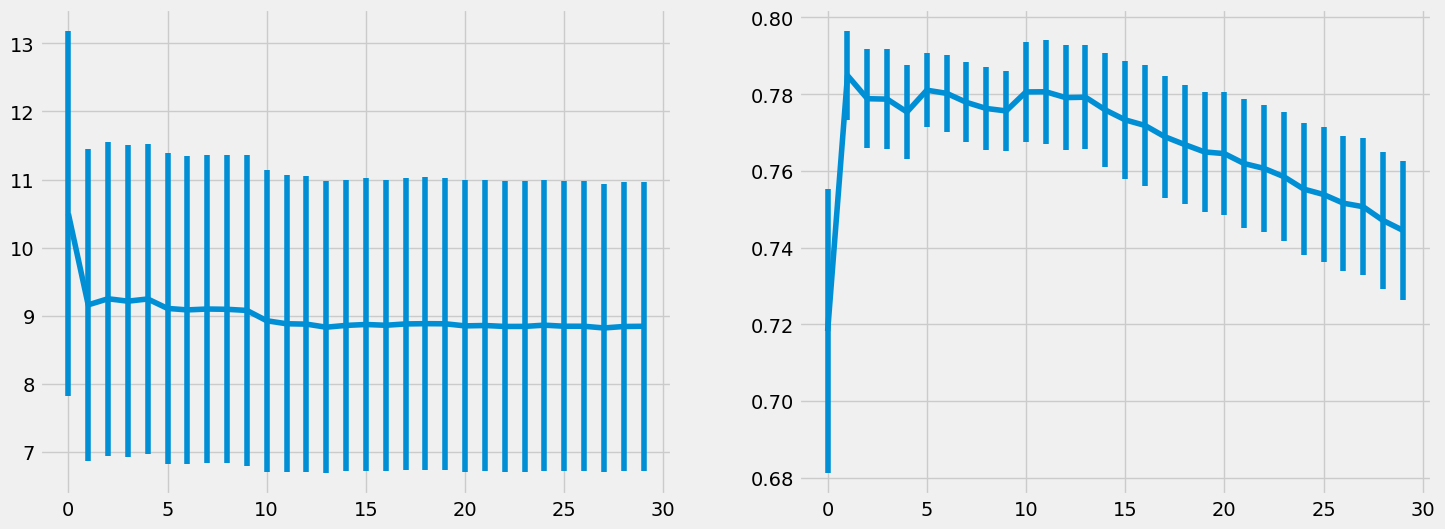

In [21]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(16,6))
#ax_rmse.set_title('')
#ax_rmse.set_xlabel("lag number")
#ax_rmse.set_ylabel("fraction of houses selecting this lag by RFECV")
#ax_r2.set_ylabel("av. PACF value across houses")
p1 = axs[0].errorbar(
            np.arange(len(sorted_lags)+1), 
            np.mean(all_rmses[clients_subset, :], axis=0), 
            np.std(all_rmses[clients_subset, :], axis=0))#label="RFECV score", c='b')
p2 = axs[1].errorbar(np.arange(len(sorted_lags)+1), 
            np.mean(all_adjr2s[clients_subset, :], axis=0), 
            np.std(all_adjr2s[clients_subset, :], axis=0))
#ax_rmse.legend(labelcolor="linecolor")
#ax_rmse.yaxis.get_label().set_color(p1.get_color())
#ax_r2.yaxis.get_label().set_color(p2.get_color())

In [22]:
num_lags_opt_r2 = np.argmax(np.mean(all_adjr2s[clients_subset, :], axis=0))
mean_rmse = np.mean(all_rmses[clients_subset, :], axis=0)
min_rmse = np.min(mean_rmse)
num_lags_opt_rmse = list(mean_rmse<min_rmse*1.01).index(True)

for num_lags_opt, met in zip([num_lags_opt_r2, num_lags_opt_rmse], ['r2', 'rmse']):
    selected_lags=sorted_lags[0:num_lags_opt]
    #selected_lag_nums = [int(x.split()[-1]) for x in selected_lags]
    #selected_lag_nums.sort()
    #print(selected_lag_nums)
    print('[INFO] the following {:2.0f} lags were selected using '.format(num_lags_opt) + met + ' criterion: ', selected_lags)

[INFO] the following  1 lags were selected using r2 criterion:  ['lag 1']
[INFO] the following 11 lags were selected using rmse criterion:  ['lag 1', 'lag 19', 'lag 2', 'lag 23', 'lag 4', 'lag 3', 'lag 121', 'lag 18', 'lag 42', 'lag 16', 'lag 120']


# save env

In [3]:
selected_lags = ['lag 1', 'lag 19', 'lag 2', 'lag 23', 'lag 4', 'lag 3', 'lag 121', 'lag 18', 'lag 42', 'lag 16', 'lag 120'] # sorted_lags[0:num_lags_opt_rmse]
if 'lag 4' in selected_lags: # NOTE: see NB 3
    selected_lags.remove('lag 4')
selected_lags = [int(x.split()[-1]) for x in selected_lags] + [6, 29]
selected_lags.sort()
print(selected_lags)
env_dict['lags'] = selected_lags
# generate env with these lags
pvdataset = PVDataset(env_dict)
env_dict = pvdataset.generate_clients_data()
# select non-ar features
non_ar_feat_keep = ['H_sun', 'station_irrad_direct_prev', 'T2m', 'WS10m']
non_ar_feat_remove = [x for x in env_dict['feature_names'] if not ((x in non_ar_feat_keep) or x.startswith('lag'))]
for feature_name in non_ar_feat_remove:
    remove_feature(
        env_dict=env_dict, 
        feature_name=feature_name, in_place=True)

# print info
print('\n'+env_dict['info'])
for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))
print('[INFO] {:2.0f} features: '.format(len(env_dict['feature_names'])), env_dict['feature_names'])

save_env = True
if save_env:
    # save env
    file = open(filename_env, 'wb')
    pickle.dump(env_dict, file)
    msg = '[INFO] saved data for {:2.0f} clients'.format(env_dict['num_clients'])
    print(msg)

[1, 2, 3, 6, 16, 18, 19, 23, 29, 42, 120, 121]
[INFO] generating data for Lausanne

24 households at Lausanne - tilt_std: 5.0, az_std: 15.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 0.8, different module_name, different inverter_name, 
sml has 150 train and 610 validation samples
1y has 610 train and 610 validation samples
5y has 3050 train and 610 validation samples
15y has 9150 train and 610 validation samples
[INFO] 16 features:  ['H_sun', 'T2m', 'WS10m', 'station_irrad_direct_prev', 'lag 1', 'lag 2', 'lag 3', 'lag 6', 'lag 16', 'lag 18', 'lag 19', 'lag 23', 'lag 29', 'lag 42', 'lag 120', 'lag 121']
[INFO] saved data for 24 clients


# Notes:
To use the generated data, first load the saved env by running


file = open(filename_env, 'rb')
env_dict = pickle.load(file)
msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients'])

* To experiment with the data-rich scenario, use 
clients_data = env_dict['train_scenarios']['5y']['clients_data']
* To experiment with the data-scarce scenario, use 
clients_data = env_dict['train_scenarios']['sml']['clients_data']


In both cases, "clients_data" is a list of length "num_clients".

For a client with number "client_num", clients_data[client_num] is a tuple of length 4, where:

x_train, y_train, x_valid, y_valid = clients_data[client_num]

In [5]:
file = open(filename_env, 'rb')
env_loaded = pickle.load(file)
msg = '[INFO] loaded data for {:2.0f} clients'.format(env_loaded['num_clients'])
print(msg)
file.close()
num_clients = env_loaded['num_clients'] 
print('\n'+env_loaded['info'])

# ----- SELECT A SUBSET OF CLIENTS -----
clients_subset= [12, 14, 15, 17, 22]
print('Subset of clients for demonstration: ', clients_subset)

num_features = len(env_loaded['feature_names'])
print('\n[INFO] {:2.0f} features: '.format(len(env_loaded['feature_names'])), *env_loaded['feature_names'])

EOFError: Ran out of input